L'objectif de ce NB est de vérifier la distribution de la solution du problème de moindres carrés linéaires. Plus précisément, on vérifie que la covariance de la loi gaussienne associée à la méthode `getParameterPosterior` est correcte pour la classe `LinearLeastSquaresCalibration`.

## Generate the observations

In [1]:
import numpy as np
import openturns as ot

In [2]:
ot.RandomGenerator.SetSeed(0)

In [3]:
def modelChaboche(X):
    strain,R,C,gamma = X
    stress = R + C*(1-np.exp(-gamma*strain))
    return [stress]

In [4]:
g = ot.PythonFunction(4, 1, modelChaboche) 

In [5]:
referenceR = 700 # Exact : 750
referenceC = 2500 # Exact : 2750
referenceGamma = 8. # Exact : 10
candidate = ot.Point([referenceR,referenceC,referenceGamma])
descr = ["R", "C", "Gamma"]
candidate.setDescription(descr)
candidate

class=Point name=Unnamed dimension=3 values=[700,2500,8]

In [6]:
parameterDimension = candidate.getDimension()
parameterDimension

3

In [7]:
Strain = ot.Uniform(0,0.07)
R = ot.Dirac(referenceR)
C = ot.Dirac(referenceC)
Gamma = ot.Dirac(referenceGamma)

Strain.setDescription(["Strain"])
R.setDescription(["R"])
C.setDescription(["C"])
Gamma.setDescription(["Gamma"])
    
inputRandomVector = ot.ComposedDistribution([Strain, R, C, Gamma])

In [8]:
def generateTheta(size, observationOutputNoise, candidate):
    # 1. Generate exact outputs
    inputSample = inputRandomVector.getSample(size)
    outputStress = g(inputSample)
    # 2. Add noise
    sampleNoiseH = observationOutputNoise.getSample(size)
    outputObservations = outputStress + sampleNoiseH
    # 3. Calibrate
    inputObservations = inputSample[:,0]
    algo = ot.LinearLeastSquaresCalibration(model, inputObservations, outputObservations, candidate, "SVD")
    algo.run()
    calibrationResult = algo.getResult()
    return calibrationResult

In [9]:
calibratedIndices = [1,2,3]
model = ot.ParametricFunction(g, calibratedIndices, candidate)

## Calibration

In [10]:
stressObservationNoiseSigma = 40. # (Pa)
observationOutputNoise = ot.Normal(0.,stressObservationNoiseSigma)

In [11]:
size = 100
calibrationResult = generateTheta(size, observationOutputNoise, candidate)

## Analysis of the results

The `getParameterMAP` method returns the maximum of the posterior distribution of $\theta$.

In [12]:
thetaStar = calibrationResult.getParameterMAP()
thetaStar

class=Point name=Unnamed dimension=3 values=[696.734,2606.25,7.5614]

In [13]:
thetaPosterior = calibrationResult.getParameterPosterior()
thetaPosterior

class=Normal name=Normal dimension=3 mean=class=Point name=Unnamed dimension=3 values=[696.734,2606.25,7.5614] sigma=class=Point name=Unnamed dimension=3 values=[15.7512,361.954,1.58663] correlationMatrix=class=CorrelationMatrix dimension=3 implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[1,0.701132,-0.763342,0.701132,1,-0.994947,-0.763342,-0.994947,1]

In [14]:
covarianceThetaStarOT = thetaPosterior.getCovariance()
covarianceThetaStarOT

class=CovarianceMatrix dimension=3 implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[248.099,3997.29,-19.0769,3997.29,131011,-571.385,-19.0769,-571.385,2.51739]

## Create an empirical sample of theta

In [15]:
resampleSize = 500
sampleTheta = ot.Sample(resampleSize,parameterDimension)
sampleTheta.setDescription(descr)
for i in range(resampleSize):
    calibrationResult = generateTheta(size, observationOutputNoise, candidate)
    thetaStar = calibrationResult.getParameterMAP()
    sampleTheta[i] = thetaStar

In [16]:
sampleTheta[0:5]

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=5 dimension=3 description=[R,C,Gamma] data=[[720.388,2915.37,6.01884],[721.673,2833.45,6.48395],[684.024,2092.79,9.88414],[677.204,1840.37,10.8661],[700.196,2716.29,7.19366]]

## Draw distributions

In [17]:
import pylab as pl
import openturns.viewer as otv

Set the mean of the posterior distribution to the candidate, so that we can compare the variances.

In [18]:
thetaPosterior

class=Normal name=Normal dimension=3 mean=class=Point name=Unnamed dimension=3 values=[696.734,2606.25,7.5614] sigma=class=Point name=Unnamed dimension=3 values=[15.7512,361.954,1.58663] correlationMatrix=class=CorrelationMatrix dimension=3 implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[1,0.701132,-0.763342,0.701132,1,-0.994947,-0.763342,-0.994947,1]

In [19]:
Sigma = thetaPosterior.getCovariance()
Sigma

class=CovarianceMatrix dimension=3 implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[248.099,3997.29,-19.0769,3997.29,131011,-571.385,-19.0769,-571.385,2.51739]

In [20]:
thetaPosteriorNormal = ot.Normal(candidate,Sigma)
thetaPosteriorNormal

class=Normal name=Normal dimension=3 mean=class=Point name=Unnamed dimension=3 values=[700,2500,8] sigma=class=Point name=Unnamed dimension=3 values=[15.7512,361.954,1.58663] correlationMatrix=class=CorrelationMatrix dimension=3 implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[1,0.701132,-0.763342,0.701132,1,-0.994947,-0.763342,-0.994947,1]

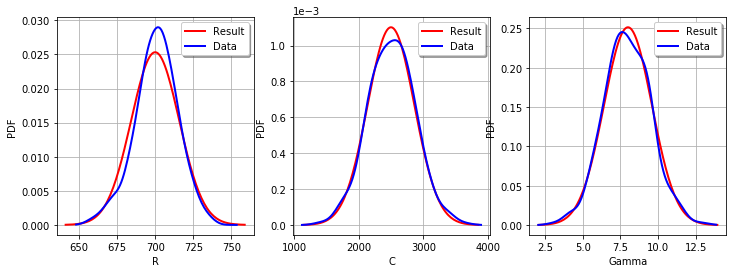

In [23]:
fig = pl.figure(figsize=(12, 4))
for i in range(parameterDimension):
    thetai = thetaPosteriorNormal.getMarginal(i)
    graph = thetai.drawPDF()
    graph.setXTitle(descr[i])
    # From data
    sampleMargin = sampleTheta.getMarginal(i)
    ksdist = ot.KernelSmoothing().build(sampleMargin).drawPDF()
    ksdist.setColors(["blue"])
    graph.add(ksdist)
    graph.setLegends(["Result","Data"])
    ax = fig.add_subplot(1, parameterDimension, i+1)
    _ = otv.View(graph, figure=fig, axes=[ax])